In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2025-05-20 05:03:47.097153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load image data #####

image_path = "/root/data/data_image.h5"
image_file = h5py.File(image_path, 'r')
image_file.keys()

<KeysViewHDF5 ['jjBG', 'sig', 'ttbarBG']>

In [3]:
sig_image = image_file['sig'][:]
print("signal shape", np.shape(sig_image))

jjBG_image = image_file['jjBG'][:]
print("jjBG shape", np.shape(jjBG_image))

ttbarBG_image = image_file['ttbarBG'][:]
print("ttbarBG shape", np.shape(ttbarBG_image))

total_image = np.concatenate((sig_image, jjBG_image, ttbarBG_image))
print("total image shape", np.shape(total_image))

signal shape (174453, 50, 50)
jjBG shape (123337, 50, 50)
ttbarBG shape (123751, 50, 50)
total image shape (421541, 50, 50)


In [4]:
##### make target #####

target = np.zeros(len(sig_image) + len(jjBG_image) + len(ttbarBG_image))
target[0:len(sig_image)] = 1    ### signal label as 1
target = to_categorical(target, num_classes=2)    ### signal label as [0, 1]
print(target)
print("target shape", np.shape(target))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
target shape (421541, 2)


In [5]:
##### split the data into training, validation and test data #####

train_image, tmp_image, train_target, tmp_target = train_test_split(total_image, target, test_size=0.4)
val_image, test_image, val_target, test_target = train_test_split(tmp_image, tmp_target, test_size=0.5)

print("training data shape:", np.shape(train_image), np.shape(train_target))
print("validation data shape:", np.shape(val_image), np.shape(val_target))
print("testing data shape:", np.shape(test_image), np.shape(test_target))

training data shape: (252924, 50, 50) (252924, 2)
validation data shape: (84308, 50, 50) (84308, 2)
testing data shape: (84309, 50, 50) (84309, 2)


In [6]:
##### build CNN model #####

CNN_model = Sequential()
CNN_model.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',data_format='channels_first', input_shape=(1,50,50)))
CNN_model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',data_format='channels_first'))
CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', data_format='channels_first'))
#CNN_model.add(BatchNormalization())

CNN_model.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',data_format='channels_first'))
CNN_model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',data_format='channels_first'))
CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', data_format='channels_first'))
#CNN_model.add(BatchNormalization())

CNN_model.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',data_format='channels_first'))
CNN_model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',data_format='channels_first'))
CNN_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', data_format='channels_first'))
#CNN_model.add(BatchNormalization())

CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(2, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
CNN_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy","mse"])

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 48, 48)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 46, 46)        1168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 23, 23)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 21, 21)         1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 19, 19)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 9, 9)          0         
 g2D)                                                   

2025-05-20 05:03:57.220734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-05-20 05:03:57.221502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


Epoch 1/2000


2025-05-20 05:04:04.846334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-05-20 05:04:06.364131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-20 05:04:06.367574: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558dd6c17400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-20 05:04:06.367618: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-20 05:04:06.367635: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-20 05:04:06.376277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-20 05:04:06.51205

494/494 [==============================] - 22s 28ms/step - loss: 0.7330 - accuracy: 0.5723 - mse: 0.2622 - val_loss: 0.6934 - val_accuracy: 0.5571 - val_mse: 0.2499
Epoch 2/2000
494/494 [==============================] - 12s 24ms/step - loss: 0.6882 - accuracy: 0.5786 - mse: 0.2474 - val_loss: 0.6836 - val_accuracy: 0.5905 - val_mse: 0.2451
Epoch 3/2000
494/494 [==============================] - 11s 23ms/step - loss: 0.6798 - accuracy: 0.5993 - mse: 0.2432 - val_loss: 0.6756 - val_accuracy: 0.6053 - val_mse: 0.2412
Epoch 4/2000
494/494 [==============================] - 12s 24ms/step - loss: 0.6718 - accuracy: 0.6121 - mse: 0.2393 - val_loss: 0.6674 - val_accuracy: 0.6151 - val_mse: 0.2371
Epoch 5/2000
494/494 [==============================] - 12s 24ms/step - loss: 0.6639 - accuracy: 0.6216 - mse: 0.2354 - val_loss: 0.6598 - val_accuracy: 0.6257 - val_mse: 0.2333
Epoch 6/2000
494/494 [==============================] - 12s 24ms/step - loss: 0.6567 - accuracy: 0.6289 - mse: 0.2318 - val

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


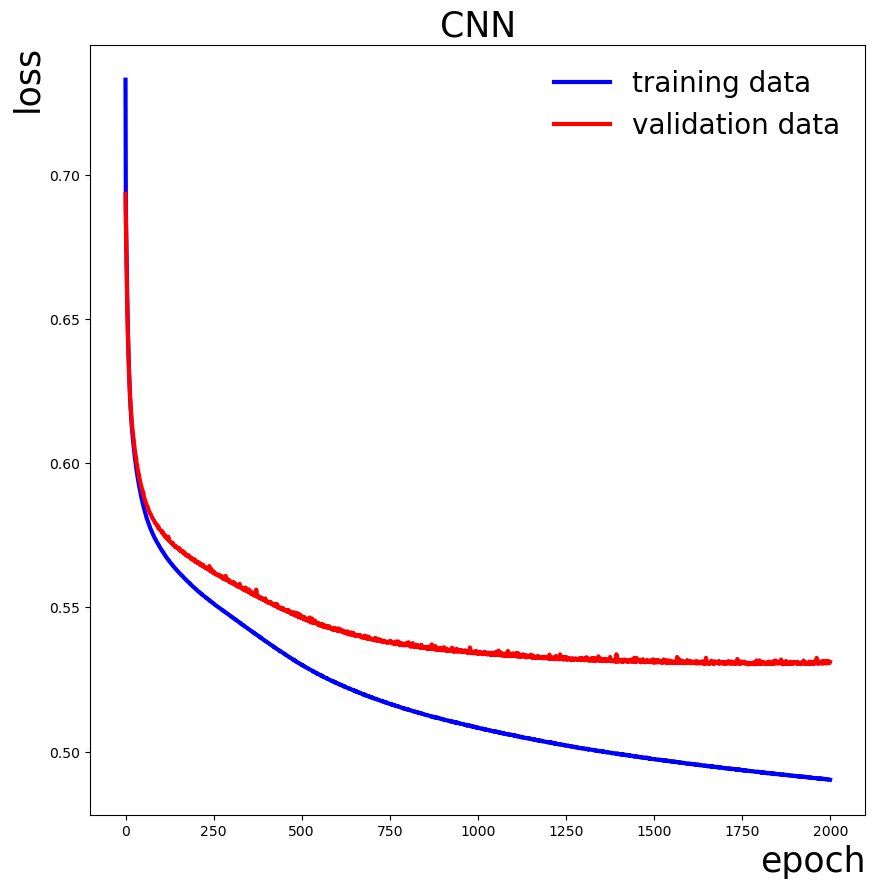

In [7]:
##### training model #####

train_len = len(train_image)
val_len = len(val_image)
batch_size = 512
epochs = 2000

tr_CNN_model = CNN_model.fit(np.reshape(train_image, (train_len,1,50,50)), train_target, validation_data=(np.reshape(val_image, (val_len,1,50,50)), val_target), batch_size=batch_size, epochs=epochs, verbose=1)
CNN_model.save("/root/data/model_CNN.h5")

### plot learning curve

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(tr_CNN_model.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(tr_CNN_model.history["val_loss"], label='validation data',c='red',linewidth = 3)
plt.title("CNN", fontsize=25)
ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

In [8]:
image_file.close()
t2 = time.time()
print("Total time (s): ", t2-t1)

Total time (s):  22337.03986930847
